# How to get started in Money Laundering

## Set up the environment

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
import itertools
import statistics
import typing

from icecream import ic
from yfiles_jupyter_graphs_for_kuzu import KuzuGraphWidget
import kuzu
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import polars as pl
import pyvis
import seaborn as sns
import watermark

from aml import Simulation

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-08-11T12:43:23.754571-07:00

Python implementation: CPython
Python version       : 3.13.3
IPython version      : 9.1.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

polars                        : 1.29.0
kuzu                          : 0.9.0
yfiles_jupyter_graphs_for_kuzu: 0.0.4
matplotlib                    : 3.10.5
networkx                      : 3.4.2
numpy                         : 2.3.2
seaborn                       : 0.13.2
pyvis                         : 0.3.2
watermark                     : 2.5.0



## Extract one fraud network

Be sure to run the `create_graph.ipynb` notebook at least once first.

Then be sure to **shutdown** the `create_graph.ipynb` notebook after running it.

In [3]:
DB_PATH = "./db"

db = kuzu.Database(DB_PATH)
conn = kuzu.Connection(db)

Create a yFiles graph widget so we can explore our graph interactively

In [4]:
g = KuzuGraphWidget(conn)

In [5]:
g.show_cypher(
    """
    MATCH (a:Entity)-[b *1..3]->(c)
    WHERE a.descrip CONTAINS "Abassin"
    RETURN * LIMIT 100;
    """,
    layout="radial"
)

GraphWidget(layout=Layout(height='650px', width='100%'))

Now let's extract the shell companies in this particular fraud network

In [6]:
res = conn.execute(
    """
    MATCH (a:Entity)-[b *1..3]->(c)
    WHERE a.descrip CONTAINS "Abassin"
      AND c.kind = "ORGANIZATION"
    RETURN c.name, COLLECT(DISTINCT c.addr)
    LIMIT 100;
    """
)

shells: dict = {
    row[0]: row[1]
    for row in res.get_as_pl().iter_rows()
}

ic(shells);

ic| shells: {'BARLLOWS SERVICES LTD': ['3 Market Parade, 41 East Street, Bromley, BR1 1QN',
                                       '31 Quernmore Close, Bromley, Kent, United Kingdom, '
                                       'BR1 4EL'],
             'LMAR (GB) LTD': ['31 Quernmore Close, Bromley, Kent, United Kingdom, BR1 '
                               '4EL'],
             'WELLHANCIA HEALTH CARE LTD': ['31 Quernmore Close, Bromley, BR1 4EL']}


## Generate synthetic data for bank transactions

In [7]:
sim: Simulation = Simulation()
sim.gen_shell_corps(shells)

Simulate a "layering" phase a few times, followed by "deals" which drain the accounts to cash out.

In [8]:
PRESS_YOUR_LUCK: int = 3

for _ in range(PRESS_YOUR_LUCK):
    sim.layer_rmf()

sim.drain_into_deals()

Export the synthetic data as a DataFrame

In [9]:
pl.Config.set_tbl_rows(-1)

df: pl.DataFrame = sim.get_xact_df()
df.head()

date,amount,remitter,receiver,descript
str,f64,str,str,str
"""2025-08-12T12:43:23.752254""",38000.0,"""Pulaski Savings""","""LMAR (GB) LTD""","""local deposit"""
"""2025-08-12T12:43:23.752254""",33000.0,"""Ranchlander National Bank""","""WELLHANCIA HEALTH CARE LTD""","""local deposit"""
"""2025-08-15T12:43:23.752254""",53000.0,"""Pulaski Savings""","""LMAR (GB) LTD""","""local deposit"""
"""2025-08-15T12:43:23.752254""",49000.0,"""Banca Socială""","""BARLLOWS SERVICES LTD""","""local deposit"""
"""2025-08-15T12:43:23.752254""",35000.0,"""Banca Socială""","""BARLLOWS SERVICES LTD""","""local deposit"""


## Construct a graph of transactions among companies

Construct a graph of the transactions between companies.

In [10]:
graph: nx.DiGraph = nx.DiGraph()
node_names: list = []
edge_xact: dict = defaultdict(list)

for row in df.rows(named = True):
    src_label: str = row["remitter"]
    dst_label: str = row["receiver"]

    if src_label not in node_names:
        node_names.append(src_label)
        src_id: int = node_names.index(src_label)

        graph.add_node(
            src_id,
            name = src_label,
        )            
    else:
        src_id = node_names.index(src_label)

    if dst_label not in node_names:
        node_names.append(dst_label)
        dst_id: int = node_names.index(dst_label)

        graph.add_node(
            dst_id,
            name = dst_label,
        )
    else:
        dst_id = node_names.index(dst_label)

    graph.add_edge(
        src_id,
        dst_id,
    )

    edge_xact[ (src_id, dst_id) ].append({
        "amount": row["amount"],
        "date": datetime.fromisoformat(str(row["date"])),
        "descript": row["descript"],
    })    

## Summary statistics

Use descriptive statistics to get a summary analysis of the transactions.

In [11]:
df.describe()

statistic,date,amount,remitter,receiver,descript
str,str,f64,str,str,str
"""count""","""45""",45.0,"""45""","""45""","""45"""
"""null_count""","""0""",0.0,"""0""","""0""","""0"""
"""mean""",null,43682.387556,null,null,null
"""std""",null,11541.572536,null,null,null
"""min""","""2025-08-12T12:43:23.752254""",2864.11,"""Amazon Marketplace""","""BARLLOWS SERVICES LTD""","""investment"""
"""25%""",null,38000.0,null,null,null
"""50%""",null,45000.0,null,null,null
"""75%""",null,53000.0,null,null,null
"""max""","""2026-03-11T12:43:23.752254""",62000.0,"""WELLHANCIA HEALTH CARE LTD""","""WELLHANCIA HEALTH CARE LTD""","""local deposit"""


How much money was transferred in total?

In [12]:
total_amount: float = round(float(df["amount"].sum()) / 10**6, 2)
print(f"total amount: ${total_amount}M")

total amount: $1.97M


## Simple forensic accounting applied

Summarize the transactions, while analyzing inter-arrival times and total amounts transferred among pairs of companies.

In [13]:
summary_data: list = []
timing_data: list = []

for edge, dat in edge_xact.items():        
    dates: list = sorted([
        xact["date"]
        for xact in dat
    ], reverse = False)

    inter_arrival: list = [
        (pair[1] - pair[0]).days
        for pair in itertools.pairwise(dates)
    ]

    timing_data.extend(inter_arrival)

    amounts: list = [
        xact["amount"]
        for xact in dat
    ]

    summary_data.append({
        "src_id": edge[0],
        "dst_id": edge[1],
        "median_amount": round(statistics.median(amounts), 2),
        "total_amount": sum(amounts),
    })

df_summary: pl.DataFrame = pl.DataFrame(
    summary_data,
)

df_summary.head()

src_id,dst_id,median_amount,total_amount
i64,i64,f64,f64
0,1,39000.0,228000.0
2,3,39000.0,78000.0
4,5,50000.0,190000.0
6,1,37500.0,75000.0
1,3,36827.31,73654.62


In [14]:
df_summary.describe()

statistic,src_id,dst_id,median_amount,total_amount
str,f64,f64,f64,f64
"""count""",26.0,26.0,26.0,26.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.923077,7.423077,44368.494615,75604.132308
"""std""",1.958021,4.640458,11135.574492,53673.464882
"""min""",0.0,1.0,2864.11,2864.11
"""25%""",1.0,3.0,39000.0,45434.11
"""50%""",3.0,8.0,45434.11,54000.0
"""75%""",5.0,11.0,51000.0,75000.0
"""max""",7.0,15.0,60000.0,228000.0


In [15]:
for node_id in graph.nodes():
    graph.nodes[node_id]["count"] = 0
    graph.nodes[node_id]["volume"] = 0
    graph.nodes[node_id]["credits"] = 0
    graph.nodes[node_id]["debits"] = 0

In [16]:
for row in df_summary.rows(named = True):
    src_id: int = row["src_id"]
    dst_id: int = row["dst_id"]
    amount: float = float(row["total_amount"])

    graph.nodes[src_id]["count"] += 1
    graph.nodes[src_id]["volume"] += amount
    graph.nodes[src_id]["debits"] += amount

    graph.nodes[dst_id]["count"] += 1
    graph.nodes[dst_id]["volume"] += amount
    graph.nodes[dst_id]["credits"] += amount

In [17]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["degree"] = degree

In [18]:
nodes_dat: typing.List[ dict ] = [
    dat
    for _, dat in graph.nodes(data = True)
]

df_nodes: pl.DataFrame = pl.DataFrame(nodes_dat)
df_nodes.head()

name,count,volume,credits,debits,degree
str,i64,f64,f64,f64,i64
"""Pulaski Savings""",1,228000.0,0.0,228000.0,1
"""LMAR (GB) LTD""",14,1.0698e6,473055.34,596711.87,14
"""Ranchlander National Bank""",1,78000.0,0.0,78000.0,1
"""WELLHANCIA HEALTH CARE LTD""",9,515094.69,199864.12,315230.57,9
"""Banca Socială""",1,190000.0,0.0,190000.0,1


In [19]:
df_nodes.describe()

statistic,name,count,volume,credits,debits,degree
str,str,f64,f64,f64,f64,f64
"""count""","""16""",16.0,16.0,16.0,16.0,16.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",null,3.25,245713.43,122856.715,122856.715,3.25
"""std""",null,3.890159,288757.831578,137849.672959,181853.100891,3.890159
"""min""","""Amazon Marketplace""",1.0,44864.11,0.0,0.0,1.0
"""25%""",null,1.0,75000.0,0.0,0.0,1.0
"""50%""",null,2.0,182055.33,89000.0,60000.0,2.0
"""75%""",null,3.0,228000.0,199864.12,190000.0,3.0
"""max""","""WELLHANCIA HEALTH CARE LTD""",14.0,1.0698e6,473055.34,596711.87,14.0


We will use these statistics later, when attempting to identify patterns of tradecraft.

## Graph analytics applied

Calculate _betweenness centrality_ measures for each node

In [20]:
ranks: dict = nx.betweenness_centrality(
    graph,
    weight = "volume",
    normalized = True,
    endpoints = True,
)

for node_id, rank in sorted(ranks.items(), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["rank"] = round(rank, 4)

    if rank > 0.0001:
        print(f"{node_id:3} rank {rank:.4}",  graph.nodes[node_id]["name"])

  1 rank 0.2542 LMAR (GB) LTD
  3 rank 0.125 WELLHANCIA HEALTH CARE LTD
  5 rank 0.125 BARLLOWS SERVICES LTD
  0 rank 0.04583 Pulaski Savings
  2 rank 0.04583 Ranchlander National Bank
  4 rank 0.04583 Banca Socială
  6 rank 0.04583 Hermitage Capital Management
  7 rank 0.04583 Amazon Marketplace
  8 rank 0.03333 Coinegg
  9 rank 0.03333 DCEX Exchange
 10 rank 0.03333 FX Alliance Traders
 11 rank 0.03333 CoinWpro
 12 rank 0.03333 BitMEX
 13 rank 0.03333 BIPPAX
 14 rank 0.03333 Bityard
 15 rank 0.03333 Pinance.io


Graph measures: _diameter_, _density_, _girth_, _node degree_

In [21]:
nx.diameter(graph.to_undirected())

3

In [22]:
nx.density(graph)

0.10833333333333334

In [23]:
nx.girth(graph.to_undirected())

3

In [24]:
node_degree: typing.List[ int ] = dict(nx.degree(graph)).values()
max(node_degree)

14

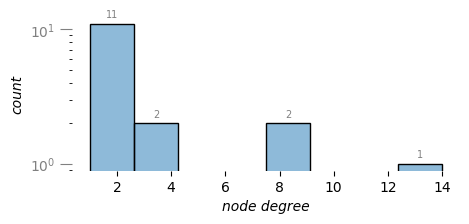

In [25]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(node_degree)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("node degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

Graph _connected components_:

In [26]:
for clique in nx.connected_components(graph.to_undirected()):
    print(clique)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [27]:
strong_edges: list = []

for clique in nx.strongly_connected_components(graph):
    if len(clique) > 1:
        strong_edges.append(sorted(list(clique)))
        print("\n", clique)

        for node_id in clique:
            dat: dict = graph.nodes[node_id]
            print(f"{node_id:3}", dat["name"])


 {1, 3, 5}
  1 LMAR (GB) LTD
  3 WELLHANCIA HEALTH CARE LTD
  5 BARLLOWS SERVICES LTD


Graph _flow analysis_:

In [28]:
nx.flow_hierarchy(graph)

0.7692307692307692

In [29]:
for node_id in nx.center(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

1 {'name': 'LMAR (GB) LTD', 'count': 14, 'volume': 1069767.21, 'credits': 473055.33999999997, 'debits': 596711.87, 'degree': 14, 'rank': 0.2542}
3 {'name': 'WELLHANCIA HEALTH CARE LTD', 'count': 9, 'volume': 515094.68999999994, 'credits': 199864.12, 'debits': 315230.56999999995, 'degree': 9, 'rank': 0.125}
5 {'name': 'BARLLOWS SERVICES LTD', 'count': 9, 'volume': 732699.2699999999, 'credits': 309934.26999999996, 'debits': 422765.0, 'degree': 9, 'rank': 0.125}
8 {'name': 'Coinegg', 'count': 3, 'volume': 249934.27, 'credits': 249934.27, 'debits': 0, 'degree': 3, 'rank': 0.0333}
11 {'name': 'CoinWpro', 'count': 3, 'volume': 214000.0, 'credits': 214000.0, 'debits': 0, 'degree': 3, 'rank': 0.0333}


In [30]:
len(list(nx.periphery(graph.to_undirected())))

11

Graph _directed flows_:

In [31]:
for node_id in graph.nodes():
    deg: int = graph.in_degree(node_id)

    if deg > 0:
        dat = graph.nodes[node_id]
        print(f"{deg:3} in degree {node_id:3}", dat["name"])

  5 in degree   1 LMAR (GB) LTD
  3 in degree   3 WELLHANCIA HEALTH CARE LTD
  3 in degree   5 BARLLOWS SERVICES LTD
  3 in degree   8 Coinegg
  2 in degree   9 DCEX Exchange
  1 in degree  10 FX Alliance Traders
  3 in degree  11 CoinWpro
  2 in degree  12 BitMEX
  2 in degree  13 BIPPAX
  1 in degree  14 Bityard
  1 in degree  15 Pinance.io


In [32]:
for node_id in graph.nodes():
    deg: int = graph.out_degree(node_id)
    graph.nodes[node_id]["out_deg"] = deg

Label the inferred "roles" for each shell company

In [33]:
for node_id in graph.nodes():
    if graph.in_degree(node_id) > 0:
        graph.nodes[node_id]["role"] = "drain"
    elif graph.out_degree(node_id) > 1:
        graph.nodes[node_id]["role"] = "multi-source"
    else:
        graph.nodes[node_id]["role"] = "source"

In [34]:
flows_dat: list = [
    {
        "node_id": node_id,
        "name": dat["name"],
        "role": dat["role"],
        "out_deg": dat["out_deg"],
        "count": dat["count"],
        "volume": dat["volume"],
        "credits": dat["credits"],
        "debits": dat["debits"],        
    }
    for node_id, dat in graph.nodes(data = True)
    if dat["out_deg"] > 0
]

df_flows: pl.DataFrame = pl.DataFrame(flows_dat)
df_flows.head()

node_id,name,role,out_deg,count,volume,credits,debits
i64,str,str,i64,i64,f64,f64,f64
0,"""Pulaski Savings""","""source""",1,1,228000.0,0.0,228000.0
1,"""LMAR (GB) LTD""","""drain""",9,14,1.0698e6,473055.34,596711.87
2,"""Ranchlander National Bank""","""source""",1,1,78000.0,0.0,78000.0
3,"""WELLHANCIA HEALTH CARE LTD""","""drain""",6,9,515094.69,199864.12,315230.57
4,"""Banca Socială""","""source""",1,1,190000.0,0.0,190000.0


In [35]:
df_flows.describe()

statistic,node_id,name,role,out_deg,count,volume,credits,debits
str,f64,str,str,f64,f64,f64,f64,f64
"""count""",8.0,"""8""","""8""",8.0,8.0,8.0,8.0,8.0
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",3.5,null,null,3.25,4.625,368570.14625,122856.71625,245713.43
"""std""",2.44949,null,null,3.24037,5.235524,370947.439839,184791.809908,190697.17798
"""min""",0.0,"""Amazon Marketplace""","""drain""",1.0,1.0,60000.0,0.0,60000.0
"""25%""",2.0,null,null,1.0,1.0,78000.0,0.0,78000.0
"""50%""",4.0,null,null,1.0,1.0,228000.0,0.0,228000.0
"""75%""",5.0,null,null,6.0,9.0,515094.69,199864.12,315230.57
"""max""",7.0,"""WELLHANCIA HEALTH CARE LTD""","""source""",9.0,14.0,1.0698e6,473055.34,596711.87


In [36]:
df_flows.group_by(["role"]).len()

role,len
str,u32
"""drain""",3
"""source""",5


## Graph visualization

In [37]:
role_colors: dict = {
    "source": "#BDC561",
    "multi-source": "#D9CAD7",
    "drain": "#C25FB8",
}

role_shapes: dict = {
    "source": "square",
    "multi-source": "diamond",
    "drain": "circle",
}

In [38]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        directed = True,
        height = "700px", 
        width = "100%",
    )
    
    # adjust node attributes
    net.from_nx(graph)

    for node in net.nodes:
        node["value"] = node["volume"]
        node["label"] = node["name"]

        node["color"] = role_colors[node["role"]]
        node["shape"] = role_shapes[node["role"]]

        title: str = node["name"] + "\nnode_id: " + str(node["id"])

        for key in [ "role", "rank", "count" ]:
            title += f"\n{key}: " + str(node[key])

        for key in [ "volume", "credits", "debits", ]:
            title += f"\n{key}: {node[key]:.3e}"
        
        node["title"] = title
    
    # adjust edge attributes
    for edge in net.edges:
        arc: list = sorted([ edge["from"], edge["to"] ])

        if arc in strong_edges:
            edge["width"] = 10

    return net

In [39]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.toggle_physics(True)

net.prep_notebook()
net.show_buttons(filter_ = [ "physics" ])

options: str =     """
  "physics": {
    "forceAtlas2Based": {
      "centralGravity": 0.04,
      "springLength": 5,
      "springConstant": 0.32,
      "avoidOverlap": 0.02
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
    """

#net.set_options(options)
# setting options via Py interface doesn't work?

net.show("aml.html")

aml.html


## Tradecraft: layering

Let's slice the data to pick out the potential instances of "layering"

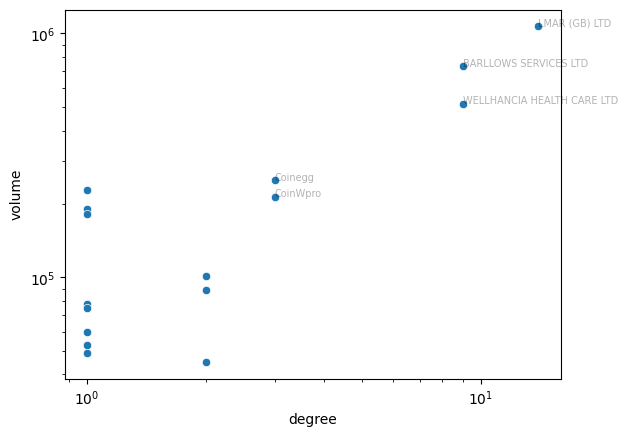

In [40]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["volume"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "degree", y = "volume")

plt.yscale("log")
plt.xscale("log")

for i, label in enumerate(labels):
    if x[i] > 2: # only label the top-ranked 14 companies
        plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

The top/right of this plot illustrates how three companies have a high degree of connections as well as large volumes of funds transacted, which could be shell companies used for "layering"

From another perspective, this plot illustrates the "sources" (negative balance, below center) and "drains" (positive balance, above center)

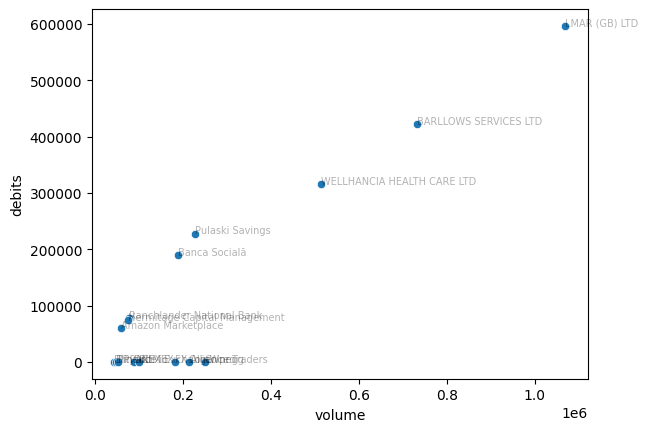

In [41]:
x: list = df_nodes["volume"].to_list()
y: list = df_nodes["debits"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "volume", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

## Tradecraft: rapid movement of funds (RMF)

Describe the distributions of transaction inter-arrival times (days in-between) and amounts

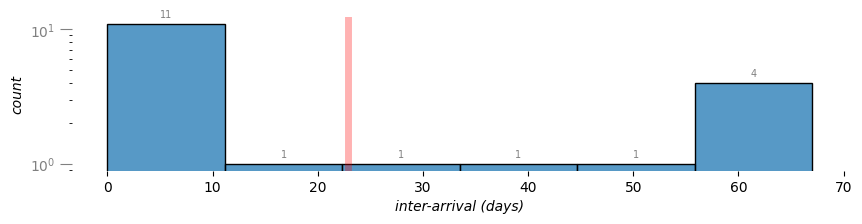

In [42]:
fig, ax = plt.subplots(figsize = (10, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(timing_data)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("inter-arrival (days)", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)

plt.axvline(x = statistics.mean(timing_data), color = "red", lw = 5, alpha = 0.3)
plt.yscale("log")

plt.legend([], [], frameon = False);

Looking at the head of the curve, there appear to be lots of relatively fast transactions? One might expect to see a plot shaped more like a Poisson distribution instead, for legit inter-arrival times.  For example:

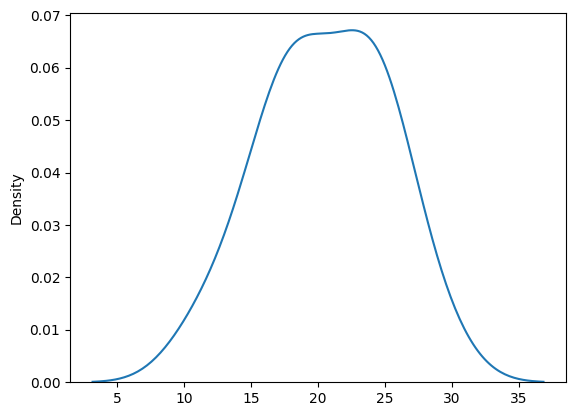

In [43]:
dat = np.random.poisson(lam = statistics.mean(timing_data), size = len(timing_data))
sns.kdeplot(dat);

## Tradecraft: remitters vs. receivers

Let's take a look at pairs companies involved in money transfers. 
One would expect that the *remitters* and *receivers* do not swith roles much, in other words the "suppliers" and "customers" of any given firm are two distinct populations.
Are there counter examples?

In [44]:
def total_pair (
    pair: tuple,
    ) -> float:
    return sum([
        item["amount"]
        for item in edge_xact[pair]
    ])


for pair in itertools.combinations(graph.nodes, 2):
    if graph.has_edge(*pair):
        rev_pair: tuple = ( pair[1], pair[0], )

        if graph.has_edge(*rev_pair):
            ic(pair, total_pair(pair), total_pair(rev_pair))

ic| pair: (1, 3)
    total_pair(pair): 73654.62
    total_pair(rev_pair): 45434.11
ic| pair: (1, 5)
    total_pair(pair): 50001.92
    total_pair(rev_pair): 64621.229999999996
ic| pair: (3, 5)
    total_pair(pair): 69932.34999999999
    total_pair(rev_pair): 48209.5


Three firms stand out -- the same ones used for "layering".